In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost

%matplotlib inline

# Import data
data = pd.read_csv('../data/data_all_features.csv')
minimal_data = pd.read_csv('../data/data_selected_features.csv')
train_test_data = pickle.load(open("../data/train_test_data_all_features", "rb"))
minimal_train_test_data = pickle.load(open("../data/train_test_data_selected_features", "rb"))
model = pickle.load(open("../data/xgb_model_pickle_v2", "rb"))

# Get samples
sample_data = train_test_data['X_test'].assign(show_up = train_test_data['y_test']).reset_index(drop=True)
minimal_sample_data = minimal_train_test_data['X_test'].assign(show_up = minimal_train_test_data['y_test']).reset_index(drop=True)

np.random.seed(42)
indices = np.random.randint(0, len(train_test_data['y_test']), 10)
sample = sample_data.loc[indices]
minimal_sample = minimal_sample_data.loc[indices]

vit = pd.read_csv('../data/no-show-300k.csv')

# Transformations required for modeling
def transform_vitoria(df):
    new_names = ['age', 'gender', 'app_registration', 'app_date', 'week_day', 'show_up',
                 'diabetes', 'alcoholism', 'hypertension', 'handicap', 'smokes', 
                 'monetary_help', 'tuberculosis', 'sms_reminder', 'days_to_appointment']
    new_order = ['age', 'gender', 'week_day', 'days_to_appointment', 'diabetes', 'alcoholism', 
                 'hypertension', 'handicap', 'smokes', 'monetary_help', 'tuberculosis', 
                 'sms_reminder', 'show_up']
    df.columns = new_names
    df = df.loc[:, new_order]
    df.loc[:, 'week_day'] = df.loc[:, 'week_day'].str.lower()
    df.loc[:, 'gender'] = df.loc[:, 'gender'].str.lower()
    df.loc[:, 'days_to_appointment'] = df.loc[:, 'days_to_appointment'] * -1
    df = df.replace({'show_up': {'Show-Up': 1, 'No-Show': 0, '2': 0}})
    
    return df

vit = transform_vitoria(vit)

/opt/conda/lib/python3.6/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Visualization

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(30, 8))

sns.distplot(vit.age, color='blue', hist=False, kde_kws={'shade':True}, ax=ax[0])
ax[0].set_title('Age', fontsize=32)

sns.distplot(vit.days_to_appointment, color='blue', hist=False, kde_kws={'shade':True}, ax=ax[1])
ax[1].set_title('Days to appointment', fontsize=32)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(30, 8))

sns.distplot(vit.loc[vit.show_up == 1].age, color='blue', hist=False, kde_kws={'shade':True}, ax=ax[0])
sns.distplot(vit.loc[vit.show_up == 0].age, color='red', hist=False, kde_kws={'shade':True}, ax=ax[0])
ax[0].set_title('Age', fontsize=32)

sns.distplot(vit.loc[vit.show_up == 1].days_to_appointment, color='blue', hist=False, kde_kws={'shade':True}, ax=ax[1])
sns.distplot(vit.loc[vit.show_up == 0].days_to_appointment, color='red', hist=False, kde_kws={'shade':True}, ax=ax[1])
ax[1].set_title('Days to appointment', fontsize=32)
ax[1].set_xlim(0, 150)

In [32]:
def plot_age_and_days_per_week_day(df, label='show_up', wday='week_day', age='age', days='days_to_appointment'):
    week_days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    week_range = range(0, 7)
    
    fig, ax = plt.subplots(2, 7, figsize=(28, 8))
    
    for i, wd in enumerate(week_days):
        for label_value, label_color in enumerate(['red', 'blue']):
            data = df.loc[df[label] == label_value].loc[df[wday] == wd].loc[:, age]
            sns.distplot(data, color=label_color, hist=False, kde_kws={'shade': True}, ax=ax[0, i])
        ax[0, i].set_title(wd.capitalize(), fontsize=24)
            
    for j, wd in enumerate(week_days):
        for label_value, label_color in enumerate(['red', 'blue']):
            data = df.loc[df[label] == label_value].loc[df[wday] == wd].loc[:, days]
            sns.distplot(data, color=label_color, hist=False, kde_kws={'shade': True}, ax=ax[1, j])
        ax[1, j].set_xlim(0, 100)

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


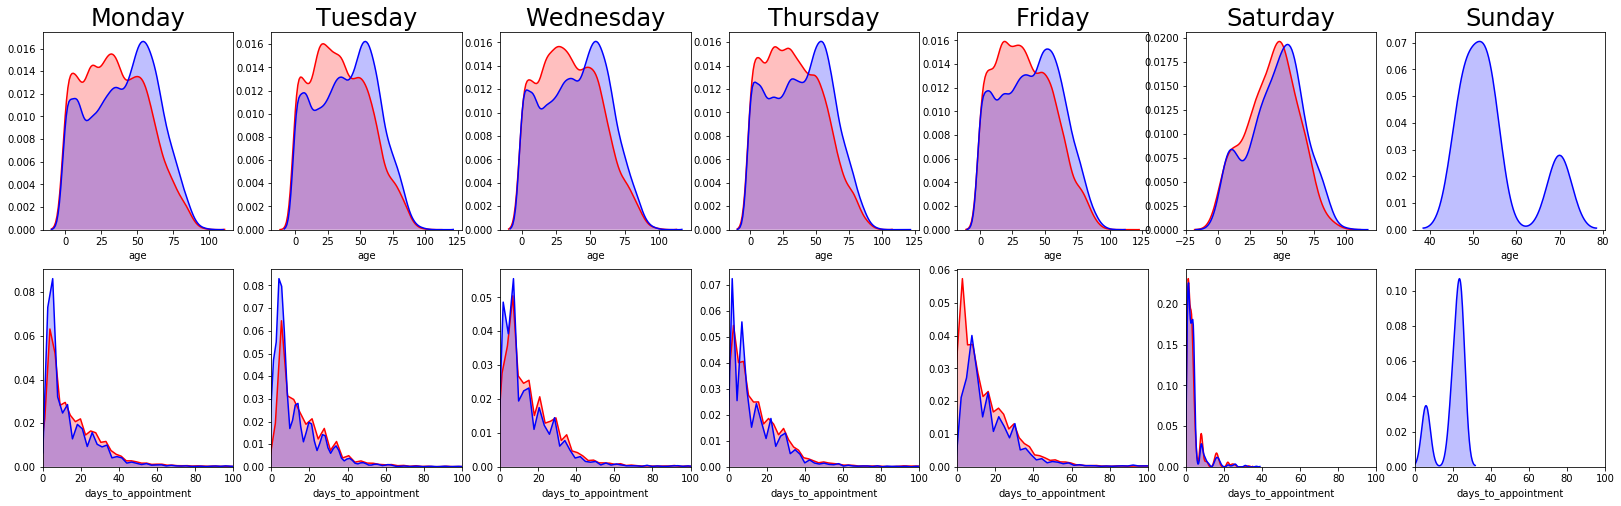

In [33]:
import visuals as vs
vs.plot_age_and_days_per_week_day(vit)

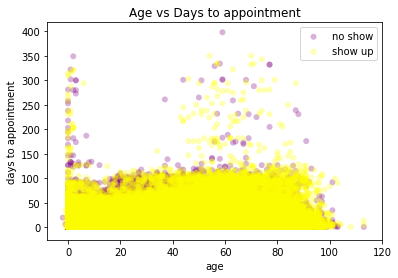

In [10]:
fig, ax = plt.subplots()
cdict = {
    0: {'color': 'purple', 'label': 'no show'},
    1: {'color': 'yellow', 'label': 'show up'}
}
for i in (0, 1):
    ax.scatter(x=vit[vit.show_up == i].age, 
               y=vit[vit.show_up == i].days_to_appointment, 
               alpha=0.3, 
               edgecolors='none', 
               c=cdict[i]['color'], 
               label=cdict[i]['label'])

# ax.scatter(x=vit.age, y=vit.days_to_appointment, c=vit.show_up, alpha=0.3, edgecolors='none')
ax.set_title('Age vs Days to appointment')
ax.set_xlabel('age')
ax.set_ylabel('days to appointment')
ax.legend()
plt.show()

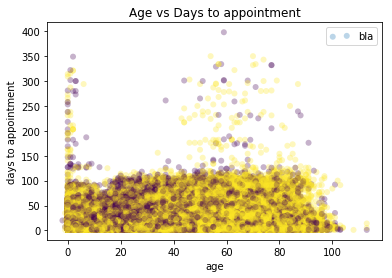

In [38]:
plot = plt.scatter(vit.age, vit.days_to_appointment, c=vit.show_up, alpha=0.3, edgecolors='none', label='bla')
# plt.scatter(vit[vit.show_up == 1].age, vit[vit.show_up == 1].days_to_appointment, alpha=0.3, edgecolors='none', c='blue', label='show up')
# plt.scatter(vit[vit.show_up == 0].age, vit[vit.show_up == 0].days_to_appointment, alpha=0.3, edgecolors='none', c='yellow', label='no show')
plt.title('Age vs Days to appointment')
plt.xlabel('age')
plt.ylabel('days to appointment')
plt.legend()
plt.show()